In [5]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.linear_model import LogisticRegression
from patsy import bs
from patsy import cr
from patsy import dmatrix, build_design_matrices

In [6]:
# Load the data (open the southafrica.R with txt the link is there)
data0 = pd.read_csv('https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data', delimiter=",")
data = data0.iloc[:,1:]
data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [7]:
X = data['tobacco']
y = data['chd']

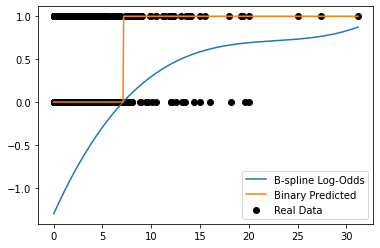

The variance for B-spline =  0.41309195854650393


In [8]:
# in cubic B-spline df = k - 2 + 1
# where k-2 is the number of internal knots and +1 is added to account for the intercept term.
bs_o = bs(X, df=4, include_intercept=True)
model_bs = LogisticRegression()
model_bs.fit(bs_o, y)

# making a new set of data form X.min() to X.max()
x_n = np.linspace(X.min(), X.max(), len(X))
bs_n = bs(x_n, df=4, include_intercept=True)

# using coefficents instead of using "predict(..., se.fit = TRUE)
log_odds_bs = model_bs.intercept_ + np.dot(bs_n, model_bs.coef_.T) 

# using logistic function which maps the log-odds to a probability between 0 and 1.
probability = 1 / (1 + np.exp(-log_odds_bs))

# predicted probabilities are converted into binary predictions by thresholding at 0.5
threshold = 0.5
binary_preds_bs = []
for p in probability:
    if p > threshold:
        binary_preds_bs.append(1)
    else:
        binary_preds_bs.append(0)
binary_preds_bs = np.array(binary_preds_bs)



plt.plot(x_n, log_odds_bs, label='B-spline Log-Odds')
plt.plot(x_n, binary_preds_bs, label='Binary Predicted')
plt.scatter(X, y, c='black', label='Real Data')
plt.legend()
plt.show()

print("The variance for B-spline = ",  np.var(y - binary_preds_bs))


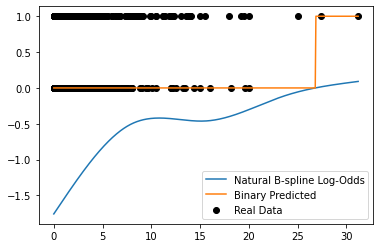

The variance for B-spline =  0.35815014711118615


In [9]:
# df = k + 3 - 1 - 2 = 5
# where k is the number of knots, 3 is the degree of the cubic spline basis
# functions, 1 is the number of additional basis functions for the intercept,
# and 2 is the number of boundary constraints for natural cubic splines.

ns_o = cr(X, df=5)
model_ns = LogisticRegression()
model_ns.fit(ns_o, y)

# making a new set of data form X.min() to X.max()
ns_n = cr(x_n, df=5)

# using coefficents instead of using "predict(..., se.fit = TRUE)
log_odds_ns = model_ns.intercept_ + np.dot(ns_n, model_ns.coef_.T)

# using logistic function which maps the log-odds to a probability between 0 and 1.
probability = 1 / (1 + np.exp(-log_odds_ns))

# predicted probabilities are converted into binary predictions by thresholding at 0.5
threshold = 0.5
binary_preds_ns = []
for p in probability:
    if p > threshold:
        binary_preds_ns.append(1)
    else:
        binary_preds_ns.append(0)
binary_preds_ns = np.array(binary_preds_ns)


plt.plot(x_n, log_odds_ns, label='Natural B-spline Log-Odds')
plt.plot(x_n, binary_preds_ns, label='Binary Predicted')
plt.scatter(X, y, c='black', label='Real Data')
plt.legend() 
plt.show()

print("The variance for B-spline = ",  np.var(y - binary_preds_ns))

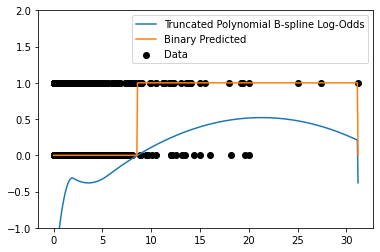

The variance for Truncated Polynomial B-spline =  0.4468994209253949


In [10]:
# Define the knots and order numbder of knots =5
knots = np.quantile(X, np.linspace(0, 1, 5))
# p is order of the polynomial used for each spline segment.
# Here, p=3 means that cubic polynomials are used.
p = 3

# Generate the truncated polynomial spline basis matrix
tr_o = dmatrix("bs(x, knots=knots, degree=p-1, include_intercept=True)", {"x": X})

# Fit the logistic regression model
model = LogisticRegression()
model.fit(tr_o, y)

# Generate the truncated polynomial spline basis matrix for new data
tr_n = build_design_matrices([tr_o.design_info], {"x": x_n})[0]

# Compute the predicted probabilities
log_odds_tr = model.intercept_ + np.dot(tr_n, model.coef_.T)

#  Clipping the log_odds values between -500 and 500 is a common approach
# to prevent overflow or underflow in the exponentiation process and improve the
# numerical stability of the computation
log_odds_clipped_tr = np.clip(log_odds_tr, -500, 500)
probability = 1 / (1 + np.exp(-log_odds_clipped_tr))


# predicted probabilities are converted into binary predictions by thresholding at 0.5
threshold = 0.5
binary_preds_tr = []
for p in probability:
    if p > threshold:
        binary_preds_tr.append(1)
    else:
        binary_preds_tr.append(0)
binary_preds_tr = np.array(binary_preds_tr)


# Plot the results
plt.plot(x_n, log_odds_tr, label='Truncated Polynomial B-spline Log-Odds')
plt.plot(x_n, binary_preds_tr, label='Binary Predicted')
plt.scatter(X, y, c='black', label='Data')
plt.ylim([-1, 2])
plt.legend() 
plt.show()

print("The variance for Truncated Polynomial B-spline = ",  np.var(y - binary_preds_tr))